# Lecture Radiographies poumons, recherche pneumonies virales ou bactériennes, Récupération dataset et réequilibrage

## 0. Import des librairies

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from pathlib import Path
import shutil
import random
import os

2024-07-03 09:16:45.936749: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-03 09:16:45.983980: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-03 09:16:46.807238: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## 1.a Récupération des données

In [2]:
CWD = Path.cwd()
TRAIN_NORMAL = CWD / "chest_Xray" / "train" / "NORMAL"
TRAIN_PNEUMONIA = CWD / "chest_Xray" / "train" / "PNEUMONIA"
TEST_NORMAL = CWD / "chest_Xray" / "test" / "NORMAL"
TEST_PNEUMONIA = CWD / "chest_Xray" / "test" / "PNEUMONIA"
VAL_NORMAL = CWD / "chest_Xray" / "val" / "NORMAL"
VAL_PNEUMONIA = CWD / "chest_Xray" / "val" / "PNEUMONIA"

In [3]:
# Déterminer le nombre d'images dans chaque répertoire
print(f"Nombre d'images dans TRAIN_NORMAL: {len(list(TRAIN_NORMAL.glob('*.jpeg')))}")
print(f"Nombre d'images dans TRAIN_PNEUMONIA: {len(list(TRAIN_PNEUMONIA.glob('*.jpeg')))}")
print(f"Nombre d'images dans TEST_NORMAL: {len(list(TEST_NORMAL.glob('*.jpeg')))}")
print(f"Nombre d'images dans TEST_PNEUMONIA: {len(list(TEST_PNEUMONIA.glob('*.jpeg')))}")
print(f"Nombre d'images dans VAL_NORMAL: {len(list(VAL_NORMAL.glob('*.jpeg')))}")
print(f"Nombre d'images dans VAL_PNEUMONIA: {len(list(VAL_PNEUMONIA.glob('*.jpeg')))}")

Nombre d'images dans TRAIN_NORMAL: 1340
Nombre d'images dans TRAIN_PNEUMONIA: 3875
Nombre d'images dans TEST_NORMAL: 234
Nombre d'images dans TEST_PNEUMONIA: 390
Nombre d'images dans VAL_NORMAL: 8
Nombre d'images dans VAL_PNEUMONIA: 8


## 1.b Réorganisation des donnnées

In [4]:
# Création de nouveaux répertoires pour les images
NEW_TRAIN = CWD / "sorted_data" / "train"
NEW_TEST = CWD / "sorted_data" / "test"
NEW_VAL = CWD / "sorted_data" / "val"

# Création des répertoires pour les catégories
for category in ["NORMAL", "BACTERIA", "VIRUS"]:
    (NEW_TRAIN / category).mkdir(parents=True, exist_ok=True)
    (NEW_TEST / category).mkdir(parents=True, exist_ok=True)
    (NEW_VAL / category).mkdir(parents=True, exist_ok=True)

# Copie des images dans les nouveaux répertoires
# Fonction pour déplacer les fichiers
def move_files(src_dir, dst_dir, condition=None):
    for file in src_dir.glob('*.jpeg'):
        if condition:
            if condition(file):
                shutil.move(str(file), dst_dir)
        else:
            shutil.move(str(file), dst_dir)

# Déplacer les images normales
move_files(TRAIN_NORMAL, NEW_TRAIN/ "NORMAL")
move_files(TEST_NORMAL, NEW_TEST / "NORMAL")
move_files(VAL_NORMAL, NEW_VAL / "NORMAL")

# Déplacer les images de pneumonie virale et bactérienne
move_files(TRAIN_PNEUMONIA, NEW_TRAIN / "VIRUS", condition=lambda f: 'virus' in f.name)
move_files(TEST_PNEUMONIA, NEW_TEST / "VIRUS", condition=lambda f: 'virus' in f.name)
move_files(VAL_PNEUMONIA, NEW_VAL / "VIRUS", condition=lambda f: 'virus' in f.name)

move_files(TRAIN_PNEUMONIA, NEW_TRAIN / "BACTERIA", condition=lambda f: 'bacteria' in f.name)
move_files(TEST_PNEUMONIA, NEW_TEST / "BACTERIA", condition=lambda f: 'bacteria' in f.name)
move_files(VAL_PNEUMONIA, NEW_VAL / "BACTERIA", condition=lambda f: 'bacteria' in f.name)

In [5]:
# Vérifier les nouvelles distributions
print(f"Nombre d'images dans TRAIN_NORMAL: {len(list((NEW_TRAIN / 'NORMAL').glob('*.jpeg')))}")
print(f"Nombre d'images dans TRAIN_VIRUS: {len(list((NEW_TRAIN / 'VIRUS').glob('*.jpeg')))}")
print(f"Nombre d'images dans TRAIN_BACTERIA: {len(list((NEW_TRAIN / 'BACTERIA').glob('*.jpeg')))}")
print(f"Nombre d'images dans TEST_NORMAL: {len(list((NEW_TEST / 'NORMAL').glob('*.jpeg')))}")
print(f"Nombre d'images dans TEST_VIRUS: {len(list((NEW_TEST / 'VIRUS').glob('*.jpeg')))}")
print(f"Nombre d'images dans TEST_BACTERIA: {len(list((NEW_TEST / 'BACTERIA').glob('*.jpeg')))}")
print(f"Nombre d'images dans VAL_NORMAL: {len(list((NEW_VAL / 'NORMAL').glob('*.jpeg')))}")
print(f"Nombre d'images dans VAL_VIRUS: {len(list((NEW_VAL / 'VIRUS').glob('*.jpeg')))}")
print(f"Nombre d'images dans VAL_BACTERIA: {len(list((NEW_VAL / 'BACTERIA').glob('*.jpeg')))}")

Nombre d'images dans TRAIN_NORMAL: 1340
Nombre d'images dans TRAIN_VIRUS: 1345
Nombre d'images dans TRAIN_BACTERIA: 2530
Nombre d'images dans TEST_NORMAL: 234
Nombre d'images dans TEST_VIRUS: 148
Nombre d'images dans TEST_BACTERIA: 242
Nombre d'images dans VAL_NORMAL: 8
Nombre d'images dans VAL_VIRUS: 0
Nombre d'images dans VAL_BACTERIA: 8


## 1.c Rééquilibrage des données 

### Redistribution des données

In [6]:
# Fonction pour déplacer un certain nombre de fichiers d'une source vers une destination
def redistribute_files(src_dir, dst_dir, num_files):
    files = list(src_dir.glob('*.jpeg'))
    random.shuffle(files)
    files_to_move = files[:num_files]
    for file in files_to_move:
        shutil.move(str(file), dst_dir)

# Chemins vers les répertoires
CWD = Path.cwd()
NEW_TRAIN = CWD / "sorted_data" / "train"
NEW_TEST = CWD / "sorted_data" / "test"
NEW_VAL = CWD / "sorted_data" / "val"

# Redistribution des images pour équilibrer les ensembles de validation
num_files_to_val = 8  # Nombre d'images à ajouter à la validation
redistribute_files(NEW_TRAIN / 'NORMAL', NEW_VAL / 'NORMAL', num_files_to_val)
redistribute_files(NEW_TRAIN / 'VIRUS', NEW_VAL / 'VIRUS', num_files_to_val)
redistribute_files(NEW_TRAIN / 'BACTERIA', NEW_VAL / 'BACTERIA', num_files_to_val)

# Redistribution des images pour équilibrer les ensembles de test
num_files_to_test = 66  # Nombre d'images à ajouter au test
redistribute_files(NEW_TRAIN / 'NORMAL', NEW_TEST / 'NORMAL', num_files_to_test)
redistribute_files(NEW_TRAIN / 'VIRUS', NEW_TEST / 'VIRUS', num_files_to_test)
redistribute_files(NEW_TRAIN / 'BACTERIA', NEW_TEST / 'BACTERIA', num_files_to_test)

# Ajout d'images supplémentaires au jeu de validation pour VIRUS
additional_files_to_val_virus = 8  # Nombre d'images supplémentaires pour équilibrer le jeu de validation pour VIRUS
redistribute_files(NEW_TRAIN / 'VIRUS', NEW_VAL / 'VIRUS', additional_files_to_val_virus)

### Vérification de la redistribution

In [7]:
# Vérification des nouvelles distributions
print(f"Nombre d'images dans TRAIN_NORMAL: {len(list((NEW_TRAIN / 'NORMAL').glob('*.jpeg')))}")
print(f"Nombre d'images dans TRAIN_VIRUS: {len(list((NEW_TRAIN / 'VIRUS').glob('*.jpeg')))}")
print(f"Nombre d'images dans TRAIN_BACTERIA: {len(list((NEW_TRAIN / 'BACTERIA').glob('*.jpeg')))}")
print(f"Nombre d'images dans TEST_NORMAL: {len(list((NEW_TEST / 'NORMAL').glob('*.jpeg')))}")
print(f"Nombre d'images dans TEST_VIRUS: {len(list((NEW_TEST / 'VIRUS').glob('*.jpeg')))}")
print(f"Nombre d'images dans TEST_BACTERIA: {len(list((NEW_TEST / 'BACTERIA').glob('*.jpeg')))}")
print(f"Nombre d'images dans VAL_NORMAL: {len(list((NEW_VAL / 'NORMAL').glob('*.jpeg')))}")
print(f"Nombre d'images dans VAL_VIRUS: {len(list((NEW_VAL / 'VIRUS').glob('*.jpeg')))}")
print(f"Nombre d'images dans VAL_BACTERIA: {len(list((NEW_VAL / 'BACTERIA').glob('*.jpeg')))}")

Nombre d'images dans TRAIN_NORMAL: 1266
Nombre d'images dans TRAIN_VIRUS: 1263
Nombre d'images dans TRAIN_BACTERIA: 2456
Nombre d'images dans TEST_NORMAL: 300
Nombre d'images dans TEST_VIRUS: 214
Nombre d'images dans TEST_BACTERIA: 308
Nombre d'images dans VAL_NORMAL: 16
Nombre d'images dans VAL_VIRUS: 16
Nombre d'images dans VAL_BACTERIA: 16


### Augmentation des Données

In [8]:
IMG_SIZE = (224, 224)

# Configuration pour l'augmentation des données
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')

def augment_data(category_dir, augment_count, augmentations_per_image=5):
    files = list(category_dir.glob('*.jpeg'))
    random.shuffle(files)
    files_to_augment = files[:augment_count]
    for file in files_to_augment:
        img = load_img(file, target_size=IMG_SIZE)
        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)
        save_prefix = 'aug_' + file.stem  # Préfixe avec le nom de fichier original
        for i, batch in enumerate(datagen.flow(x, batch_size=1, save_to_dir=category_dir, save_prefix=save_prefix, save_format='jpeg')):
            if i >= augmentations_per_image - 1:
                break

# Augmenter les données pour l'entraînement
augment_data(NEW_TRAIN / 'NORMAL', 500)
augment_data(NEW_TRAIN / 'VIRUS', 500)
augment_data(NEW_TRAIN / 'BACTERIA', 500)

# Augmenter les données pour la validation
augment_data(NEW_VAL / 'NORMAL', 50)
augment_data(NEW_VAL / 'VIRUS', 50)
augment_data(NEW_VAL / 'BACTERIA', 50)

In [9]:
# Prétraitement et création des datasets avec tf.data
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image /= 255.0  # Normalisation
    label = tf.strings.split(path, os.sep)[-2]  # Extraire le label du chemin
    return image, label

def get_dataset(directory):
    dataset = tf.data.Dataset.list_files(str(directory / '*/*.jpeg'))
    dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return dataset

train_dataset = get_dataset(NEW_TRAIN)
val_dataset = get_dataset(NEW_VAL)
test_dataset = get_dataset(NEW_TEST)

AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32

train_dataset = train_dataset.cache().shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

2024-07-03 09:17:43.286124: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-03 09:17:43.332611: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-03 09:17:43.338413: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

### Vérification de la répartition

In [10]:
# Vérification des nouvelles distributions après augmentation
print(f"Nombre d'images dans TRAIN_NORMAL: {len(list((NEW_TRAIN / 'NORMAL').glob('*.jpeg')))}")
print(f"Nombre d'images dans TRAIN_VIRUS: {len(list((NEW_TRAIN / 'VIRUS').glob('*.jpeg')))}")
print(f"Nombre d'images dans TRAIN_BACTERIA: {len(list((NEW_TRAIN / 'BACTERIA').glob('*.jpeg')))}")
print(f"Nombre d'images dans TEST_NORMAL: {len(list((NEW_TEST / 'NORMAL').glob('*.jpeg')))}")
print(f"Nombre d'images dans TEST_VIRUS: {len(list((NEW_TEST / 'VIRUS').glob('*.jpeg')))}")
print(f"Nombre d'images dans TEST_BACTERIA: {len(list((NEW_TEST / 'BACTERIA').glob('*.jpeg')))}")
print(f"Nombre d'images dans VAL_NORMAL: {len(list((NEW_VAL / 'NORMAL').glob('*.jpeg')))}")
print(f"Nombre d'images dans VAL_VIRUS: {len(list((NEW_VAL / 'VIRUS').glob('*.jpeg')))}")
print(f"Nombre d'images dans VAL_BACTERIA: {len(list((NEW_VAL / 'BACTERIA').glob('*.jpeg')))}")

Nombre d'images dans TRAIN_NORMAL: 3766
Nombre d'images dans TRAIN_VIRUS: 3763
Nombre d'images dans TRAIN_BACTERIA: 4955
Nombre d'images dans TEST_NORMAL: 300
Nombre d'images dans TEST_VIRUS: 214
Nombre d'images dans TEST_BACTERIA: 308
Nombre d'images dans VAL_NORMAL: 96
Nombre d'images dans VAL_VIRUS: 96
Nombre d'images dans VAL_BACTERIA: 96


## 2. Vérification du visual des images augmentées

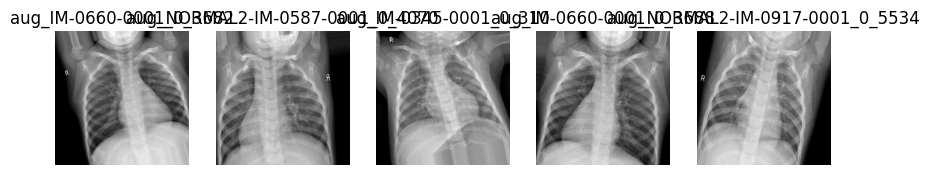

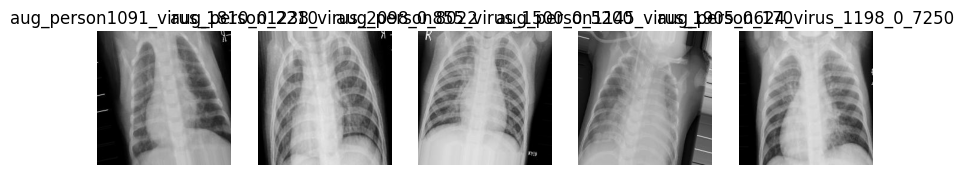

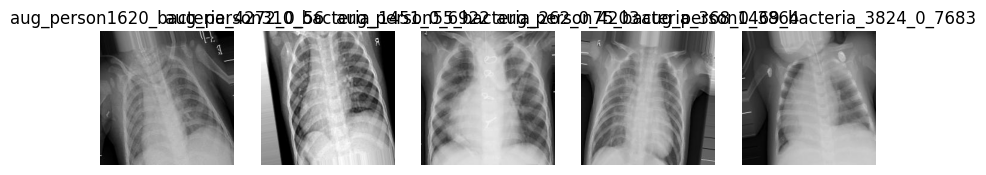

In [11]:
def show_augmented_images(category_dir, num_images=5):
    files = list(category_dir.glob('*.jpeg'))
    aug_files = [file for file in files if 'aug_' in file.stem]
    random.shuffle(aug_files)
    selected_files = aug_files[:num_images]
    plt.figure(figsize=(10, 10))
    for i, file in enumerate(selected_files):
        img = load_img(file, target_size=IMG_SIZE)
        ax = plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(file.stem)
        plt.axis('off')
    plt.show()

# Afficher quelques exemples d'images augmentées
show_augmented_images(NEW_TRAIN / 'NORMAL')
show_augmented_images(NEW_TRAIN / 'VIRUS')
show_augmented_images(NEW_TRAIN / 'BACTERIA')